# Audio Classification with Hugging Face Transformers
**author: Alessandro D'Amico**

This code was adapted from an original version
credits to *Sreyan Ghosh* for the original version of this notebook, reachable at the following link:

- [ Training Wav2Vec 2.0 using Hugging Face Transformers for Audio Classification](https://github.com/keras-team/keras-io/blob/master/examples/audio/wav2vec2_audiocls.py)


## N.B.: Requirements
- RAM > 13 GB
- VRAM > 15 GB

## Introduction

Identification of speech commands, also known as *keyword spotting* (KWS),
is important from an engineering perspective for a wide range of applications,
from indexing audio databases and indexing keywords, to running speech models locally
on microcontrollers. Currently, many human-computer interfaces (HCI) like Google
Assistant, Microsoft Cortana, Amazon Alexa, Apple Siri and others rely on keyword
spotting. There is a significant amount of research in the field by all major companies,
notably Google and Baidu.

In the past decade, deep learning has led to significant performance
gains on this task. Though low-level audio features extracted from raw audio like MFCC or
mel-filterbanks have been used for decades, the design of these low-level features
are [flawed by biases](https://arxiv.org/abs/2101.08596). Moreover, deep learning models
trained on these low-level features can easily overfit to noise or signals irrelevant to the
task.  This makes it is essential for any system to learn speech representations that make
high-level information, such as acoustic and linguistic content, including phonemes,
words, semantic meanings, tone, speaker characteristics from speech signals available to
solve the downstream task. [Wav2Vec 2.0](https://arxiv.org/abs/2006.11477), which solves a
self-supervised contrastive learning task to learn high-level speech representations,
provides a great alternative to traditional low-level features for training deep learning
models for KWS.

In this notebook, we train the Wav2Vec 2.0 to recognize the leading emotion, using IEMOCAP (audio files) as dataset.

## Importing IEMOCAP

In [1]:
!pip install tensorflow-addons
!pip3 install -q git+https://github.com/vasudevgupta7/gsoc-wav2vec2@main
!sudo apt-get install -y libsndfile1-dev
!pip3 install -q SoundFile

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 12.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 35.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 24.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 22.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.8 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libsndfile1-dev is already the newest version (1.0.28-7ubuntu0.1).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


#### Downloading IEMOCAP from private repository (using `kaggle.json` API Key for enabled users)

In [2]:
from IPython.display import Audio, clear_output
from google.colab import files
import pandas as pd
import os
import numpy as np
import tensorflow_addons as tfa
from IPython.display import Audio
import random
!pip install git+https://github.com/huggingface/transformers.git
from transformers import AutoFeatureExtractor



files.upload()
!ls -lha kaggle.json
!pip install -q kaggle # Install kaggle API
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d riccardopaolini/nlp-project-work
!unzip nlp-project-work.zip
clear_output()

folder = os.path.join(os.getcwd(), 'IEMOCAP')

conv_id = 0

### Building IEMOCAP Pandas DataFrame

In [3]:
df = []
for session in ['Session1','Session2','Session3','Session4','Session5']:
    session_path = os.path.join(folder, session)
    # 'dialogue' folder contains Emotions and Transcripts
    # 'sentences' folder contains Audios

    trans_folder = os.path.join(session_path, 'dialog', 'transcriptions')

    for trans_name in np.sort(os.listdir(trans_folder)):
        if trans_name[:2] != '._':
            emo_path = os.path.join(session_path, 'dialog', 'EmoEvaluation', trans_name)
            with open(os.path.join(trans_folder, trans_name), encoding='utf8') as trans_file, open(emo_path, encoding='utf8') as emo_file:
                conv_id += 1
                turn_id = 0
                for line in trans_file:
                    audio_name, text = line.split(':')
                    if trans_name.split('.')[0] in audio_name:
                        turn_id += 1

                        wav_path = os.path.join(session_path, 'sentences', 'wav', trans_name.split('.')[0], audio_name.split(' ')[0] + '.wav')

                        reached = False
                        count_em = {'Anger': 0, 'Happiness': 0, 'Sadness': 0, 'Neutral': 0, 'Frustration': 0, 'Excited': 0, 'Fear': 0, 'Surprise': 0, 'Disgust': 0, 'Other': 0}
                        for emo_line in emo_file:
                            if audio_name.split(' ')[0] in emo_line:
                                emotion, vad = emo_line.split('\t')[-2:]
                                vad = vad[1:-2].split(',')
                                reached = True
                            elif emo_line[0] == 'C' and reached:
                                evaluator = emo_line.split(':')[0]
                                emotions = emo_line.split(':')[1].split('(')[0].split(';')
                                emotions = [em.strip() for em in emotions]
                                for em in emotions:
                                    if em != '':
                                        count_em[em] += 1
                            elif reached:
                                emo_file.seek(0)
                                break
                                    

                        row = {'session_id': int(session[-1]),
                                'conv_id': conv_id, 
                                'turn_id': turn_id, 
                                'sentence': text.strip(),
                                'path': wav_path,
                                'emotion': emotion,
                                'valence': float(vad[0]),
                                'activation': float(vad[1]),
                                'dominance': float(vad[2])
                                }
                        
                        df.append(dict(**row, **count_em))

df = pd.DataFrame(df)

idx = np.array([os.path.exists(path) for path in df.path])
print(f'Missing Audios: {np.sum(~idx)}')
print('Missing Sentences:')
print(df.iloc[~idx,3])
df = df.iloc[idx, :]

Missing Audios: 48
Missing Sentences:
3854    [LAUGHTER], That's what they say.
3866                            Mmm, Hmm.
3880                                Yeah.
3898                               Kelly.
3915                           Yeah, man.
3939                      Uh-huh, uh-huh.
3961                              Uh-huh.
3968                                Yeah.
3972                                Yeah.
4010                       Well, I don't-
4044                                Yeah.
4827                        But, Listen--
4847                                Yeah.
4873                                Yeah.
4975                          We- I mean-
4991                                Okay.
5005                                Yeah.
5051                              Thanks.
5124                        to start off.
5181                                okay.
5192                                Okay.
5208                                Okay.
7893                                  

In [4]:
print(df.shape)

(10039, 19)


In [5]:
df.head()

,session_id,conv_id,turn_id,sentence,path,emotion,valence,activation,dominance,Anger,Happiness,Sadness,Neutral,Frustration,Excited,Fear,Surprise,Disgust,Other
0,1,1,1,Excuse me.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,0,0,0,4,0,0,0,0,0,0
1,1,1,2,Do you have your forms?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,1,3,0,0,0,0,1
2,1,1,3,Yeah.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,4,0,0,0,0,0,0
3,1,1,4,Let me see them.,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,fru,2.5,2.0,2.5,0,0,0,0,3,0,0,0,0,1
4,1,1,5,Is there a problem?,/content/IEMOCAP/Session1/sentences/wav/Ses01F...,neu,2.5,2.5,2.5,1,0,0,3,0,0,0,1,0,0


## Global variables

In [6]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 1
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 1  # Batch-size for training and evaluating our model.
# Datasets has to be of a size that is multiple of this: // BATCH_SIZE) * BATCH_SIZE
NUM_CLASSES = 11  # Number of classes our dataset will have (11 in our case).
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 49
MAX_EPOCHS = 2  # Maximum number of training epochs.

MODEL_CHECKPOINT = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hub

## Input Preprocessing

### Converting audio samples

In [9]:
import soundfile as sf

def read_wav_file(file_path):
  with open(file_path, "rb") as f:
      audio, sample_rate = sf.read(f)
  if sample_rate != SAMPLING_RATE:
      raise ValueError(
          f"sample rate (={sample_rate}) of your files must be {SAMPLING_RATE}"
      )
  file_id = os.path.split(file_path)[-1][:-len(".wav")]
  return audio #.tolist()

feature_extractor = AutoFeatureExtractor.from_pretrained(
    MODEL_CHECKPOINT, return_attention_mask=True
)


def preprocess_function(audio_arrays):
    #audio_arrays: audio files encoded in float nums
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding=True,
    )
    return inputs

Before we can feed the audio utterance samples to our model, we need to
pre-process them. This is done by a Hugging Face Transformers "Feature Extractor"
which will (as the name indicates) re-sample your the inputs to sampling rate
the the model expects (in-case they exist with a different sampling rate), as well
as generate the other inputs that model requires.

To do all of this, we instantiate our `Feature Extractor` with the
`AutoFeatureExtractor.from_pretrained`, which will ensure:

We get a `Feature Extractor` that corresponds to the model architecture we want to use.
We download the config that was used when pretraining this specific checkpoint.
This will be cached so it's not downloaded again the next time we run the cell.

The `from_pretrained()` method expects the name of a model from the Hugging Face Hub. This is
exactly similar to `MODEL_CHECKPOINT` and we just pass that.

In [24]:
# getting audios
audio_paths = df.iloc[:,4].to_list()

def audio_converter(audio_paths):
    # getting array of float samples composing each audio
    audio_samples = list(map(read_wav_file, audio_paths))

    print(f'Audios in the dataset: {len(audio_samples)}')

    preproc_audio = preprocess_function(audio_samples)
    sounds_converted  = { 'input_values': np.array(preproc_audio['input_values']),'attention_mask':np.array(preproc_audio['attention_mask'])}

    return sounds_converted

X = audio_converter(audio_paths=audio_paths)

Audios in the dataset: 10039


### Converting text labels

In [25]:
encoded_dict= {'ang':0, 'dis':1, 'exc':2, 'fea':3, 'fru':4, 'hap':5,'neu':6, 'oth':7, 'sad':8, 'sur':9, 'xxx':10}

y = df.emotion.map(encoded_dict).to_numpy()

In [26]:
print(f'Labeled rows: {len(y)}')

Labeled rows: 10039


## Dataset Splitting

In [ ]:
splits = np.array([0.8,0.1,0.1])

def split_dataset(X, y, splits):
    
    if np.sum(splits) != 1:
      raise Exception ('Splits division is not valid, their sum must be == 1')
    
    if len(X) != len(y):
      raise Exception ('X and y must have same number of rows')
    


    n_split_train_val = int(splits[0] * len(y))

    n_split_val_test = int((splits[0]+splits[1]) * len(y))

    train_X, train_y = (X[:n_split_train_val], y[:n_split_train_val])
    val_X, val_y = (X[n_split_train_val:n_split_val_test], y[n_split_train_val:n_split_val_test])
    test_X, test_y = (X[n_split_val_test:], y[n_split_val_test:])

return train_X, train_y, val_X, val_y, test_X, test_y

train_X, train_y, val_X, val_y, test_X, test_y =  split_dataset(X=X, y=y, splits=splits)

assert len(X_train) == len(y_train)
assert len(X_val) == len(y_val)
assert len(X_test) == len(y_test)
assert len(X_train)+len(X_val)+len(X_test) == len(X)
assert len(y_train)+len(y_val)+len(y_test) == len(y)

print('Train dimensions: ', len(X_train), len(y_train))
print('Val dimensions: ', len(X_val), len(y_val))
print('Test dimensions:', len(X_test), len(y_test) )

## Setup

### Installing the requirements

In [27]:
!pip install git+https://github.com/huggingface/transformers.git
!pip install huggingface-hub
!pip install joblib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/huggingface/transformers.git to /tmp/pip-req-build-_mv6i6ha
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers.git /tmp/pip-req-build-_mv6i6ha
  Resolved https://github.com/huggingface/transformers.git to commit cf11493dce0a1d22446efe0d6c4ade02fd928e50
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


### Importing the necessary libraries

In [28]:
import random
import logging

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Only log error messages
tf.get_logger().setLevel(logging.ERROR)
# Set random seed
tf.keras.utils.set_random_seed(42)

### Define certain variables

## Defining the Wav2Vec 2.0 with Classification-Head

We now define our model. To be precise, we define a Wav2Vec 2.0 model and add a
Classification-Head on top to output a probability ditribution of all classes for each
input audio sample. Since the model might get complex we first define the Wav2Vec
2.0 model with Classification-Head as a Keras layer and then build the model using that.

We instantiate our main Wav2Vec 2.0 model using the `TFWav2Vec2Model` class. This will
instantiate a model which will output 768 or 1024 dimensional embeddings according to
the config you choose (BASE or LARGE). The `from_pretrained()` additionally helps you
load pre-trained weights from the Hugging Face Model Hub. It will download the pre-trained weights
together with the config corresponding to the name of the model you have mentioned when
calling the method. For our task, we choose the BASE variant of the model that has
just been pre-trained, since we fine-tune over it.

In [29]:
from transformers import TFWav2Vec2Model


def mean_pool(hidden_states, feature_lengths):
    attenion_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=tf.dtypes.int64
    )
    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attenion_mask, [-1]), -1), [-1]),
        dtype=tf.dtypes.bool,
    )
    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(~padding_mask, -1), (BATCH_SIZE, MAX_FRAMES, HIDDEN_DIM)
        ),
        0.0,
        hidden_states,
    )
    pooled_state = tf.math.reduce_sum(hidden_states, axis=1) / tf.reshape(
        tf.math.reduce_sum(tf.cast(padding_mask, dtype=tf.dtypes.float32), axis=1),
        [-1, 1],
    )
    return pooled_state


class TFWav2Vec2ForAudioClassification(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        # Instantiate the Wav2Vec 2.0 model without the Classification-Head
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        # Drop-out layer before the final Classification-Head
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        # Classification-Head
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # We take only the first output in the returned dictionary corresponding to the
        # output of the last layer of Wav2vec 2.0
        hidden_states = self.wav2vec2(inputs["input_values"])[0]

        # If attention mask does exist then mean-pool only un-masked output frames
        if tf.is_tensor(inputs["attention_mask"]):
            # Get the length of each audio input by summing up the attention_mask
            # (attention_mask = (BATCH_SIZE x MAX_SEQ_LENGTH) ∈ {1,0})
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            # Get the number of Wav2Vec 2.0 output frames for each corresponding audio input
            # length
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths)
        # If attention mask does not exist then mean-pool only all output frames
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state


## Building and Compiling the model

We now build and compile our model. We use the `SparseCategoricalCrossentropy`
to train our model since it is a classification task. Following much of literature
we evaluate our model on the `accuracy` metric.

In [30]:

def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    # Compile and return
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model


model = build_model()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tine this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['project_q.bias', 'quantizer.weight_proj.weight', 'quantizer.weight_proj.bias', 'quantizer.codevectors', 'project_q.weight', 'project_hid.bias', 'project_hid.weight']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

## Training the model

In [31]:
print(y)

[6 4 6 ... 0 0 0]


In [32]:
model.fit(X,y,
    validation_data=(X,y),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS
) #train_x,train["label"],(test_x, test["label"])

Epoch 1/2
10039/10039 [==============================] - 586s 54ms/step - loss: 1.9755 - accuracy: 0.2066 - val_loss: 1.9241 - val_accuracy: 0.2398
Epoch 2/2
 8181/10039 [=======================>......] - ETA: 1:25 - loss: 1.9440 - accuracy: 0.2226

KeyboardInterrupt: ignored

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 16000)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 16000)]      0           []                               
                                                                                                  
 tf_wav2_vec2_for_audio_classif  (None, 11)          94380171    ['input_4[0][0]',                
 ication_1 (TFWav2Vec2ForAudioC                                   'input_3[0][0]']                
 lassification)                                                                                   
                                                                                            

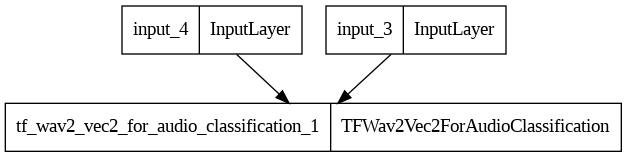

In [33]:
model.summary()
tf.keras.utils.plot_model(model)


Great! Now that we have trained our model, we predict the classes
for audio samples in the test set using the `model.predict()` method! We see
the model predictions are not that great as it has been trained on a very small
number of samples for just 1 epoch. For best results, we reccomend training on
the complete dataset for at least 5 epochs!

In [ ]:
preds = model.predict(test_x)

Now we try to infer the model we trained on a randomly sampled audio file.
We hear the audio file and then also see how well our model was able to predict!

In [ ]:
import IPython.display as ipd

rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=True, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])

Now you can push this model to Hugging Face Model Hub and also share it with with all your friends,
family, favorite pets: they can all load it with the identifier
`"your-username/the-name-you-picked"`, for instance:

```python
model.push_to_hub("wav2vec2-ks", organization="keras-io")
tokenizer.push_to_hub("wav2vec2-ks", organization="keras-io")
```
And after you push your model this is how you can load it in the future!

```python
from transformers import TFWav2Vec2Model

model = TFWav2Vec2Model.from_pretrained("your-username/my-awesome-model", from_pt=True)
```